# Идентификация трещин на изображениях рельсов

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from skimage.io import imread_collection, imshow
from skimage.color import rgb2gray
from skimage.transform import rotate, resize
from skimage.exposure import adjust_log, adjust_gamma
from skimage.filters import threshold_mean, gaussian
from skimage.measure import label, regionprops

from keras import optimizers 
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, UpSampling2D
        
import keras.backend as K
        
%matplotlib inline

Using TensorFlow backend.


## Подготавливаем набор данных

### Загрузим изображения и маски из датасета

In [2]:
images = imread_collection('dataset\Type-I RSDDs dataset\Rail surface images\*.jpg', True)
masks = imread_collection('dataset\Type-I RSDDs dataset\GroundTruth\*.jpg', True)

print('Изображений в датасете: {}, {}'.format(len(images), len(masks)))

Изображений в датасете: 67, 67


### Проведем аугментацию данных (случайные number_of_subsamples фрагментов изображения)

In [3]:
sample_size = 128
number_of_subsamples = 15

augmented_dataset = []

for i, img in enumerate(images):
    gray_image = rgb2gray(img)
    gray_mask = rgb2gray(masks[i])
    
    for _ in range(number_of_subsamples):
        # Получаем случайные координаты
        random_x = random.randint(0, gray_image.shape[1] - sample_size)
        random_y = random.randint(0, gray_image.shape[0] - sample_size)
        
        # Берем случайный квадрат изображения
        random_image_subsample = gray_image[random_y:random_y+sample_size, random_x:random_x+sample_size]
        random_mask_subsample = gray_mask[random_y:random_y+sample_size, random_x:random_x+sample_size]
        
        # Убираем шумы
        random_mask_subsample = gaussian(random_mask_subsample)
        
        # Если в регион попал дефект
        if np.count_nonzero(random_mask_subsample) / (sample_size * sample_size) >= 0:        
            # Вращаем образцы
            for angle in range(0, 360, 10):
                rotated_random_image_subsample = rotate(random_image_subsample, angle)
                rotated_random_mask_subsample = rotate(random_mask_subsample, angle)
                    
                # Находим регион дефекта
                labels = label(rotated_random_mask_subsample)
                regions = regionprops(labels)
                    
                if len(regions) == 1:
                    rotated_random_mask_region_center = np.array((regions[0].centroid[0], regions[0].centroid[1]))
                    augmented_dataset.append((rotated_random_image_subsample,
                                              rotated_random_mask_subsample,
                                              rotated_random_mask_region_center))
        
np.random.shuffle(augmented_dataset)

np.save('dataset.npy', augmented_dataset)
        
print('Размер набора данных: {}'.format(len(augmented_dataset)))

Размер набора данных: 2111


### Посмотрим на результат аугментации

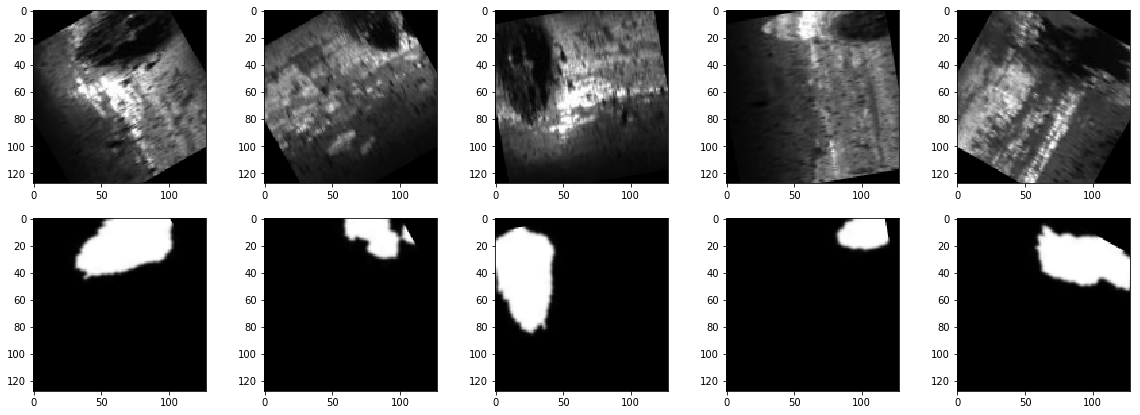

In [4]:
augmented_dataset = np.load('dataset.npy')

fig, ax = plt.subplots(2, 5, figsize=(20, 7))
for i in range(5):
    rnd = np.random.randint(0, len(augmented_dataset))
    ax[0, i].imshow(augmented_dataset[rnd][0], cmap='gray')
    ax[1, i].imshow(augmented_dataset[rnd][1], cmap='gray')

### Подготовим данные для обучения

In [5]:
dataset = np.load('dataset.npy')

train_ratio = 0.9
train, test = dataset[:int(len(dataset) * train_ratio)], dataset[int(len(dataset) * train_ratio):]

train_x, train_y, test_x, test_y = train[:, 0], train[:, 2], test[:, 0], test[:, 2]

print('В обучающем наборе элементов: {}, в тестовом {}'.format(len(train_x), len(test_x)))

В обучающем наборе элементов: 1899, в тестовом 212


### Преобразуем данные к 4D формату

In [6]:
train_x_norm = np.array([d.reshape((sample_size, sample_size, 1)) for d in train_x]).astype(np.float32)
train_y_norm = np.array([d for d in train_y]).astype(np.float32) / (sample_size)
test_x_norm = np.array([d.reshape((sample_size, sample_size, 1)) for d in test_x]).astype(np.float32)
test_y_norm = np.array([d for d in test_y]).astype(np.float32) / (sample_size)

### Строим модель FCN-сети

In [7]:
model = Sequential()

model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(sample_size, sample_size, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))

model.add(Dense(2))
model.add(Activation("linear"))

model.compile(loss='mse', optimizer='adam', metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
__________

### Обучаем нейронную сеть

In [19]:
history = model.fit(train_x_norm, train_y_norm, validation_data=(test_x_norm, test_y_norm), epochs=30, batch_size=20)

Train on 2005 samples, validate on 223 samples
Epoch 1/30
2005/2005 [==============================] - 134s 67ms/step - loss: 0.1078 - acc: 0.5087 - val_loss: 0.0746 - val_acc: 0.5291
Epoch 2/30
2005/2005 [==============================] - 132s 66ms/step - loss: 0.0767 - acc: 0.4873 - val_loss: 0.0782 - val_acc: 0.5426
Epoch 3/30
2005/2005 [==============================] - 131s 65ms/step - loss: 0.0711 - acc: 0.5596 - val_loss: 0.0435 - val_acc: 0.8296
Epoch 4/30
2005/2005 [==============================] - 127s 63ms/step - loss: 0.0291 - acc: 0.8673 - val_loss: 0.0182 - val_acc: 0.9283
Epoch 5/30
2005/2005 [==============================] - 126s 63ms/step - loss: 0.0185 - acc: 0.9052 - val_loss: 0.0145 - val_acc: 0.9462
Epoch 6/30
2005/2005 [==============================] - 127s 63ms/step - loss: 0.0110 - acc: 0.9337 - val_loss: 0.0066 - val_acc: 0.9417
Epoch 7/30
2005/2005 [==============================] - 127s 63ms/step - loss: 0.0064 - acc: 0.9431 - val_loss: 0.0046 - val_acc: 0

### Сохраняем нейронную сеть

In [20]:
model.save('network')

### Проводим валидацию на тестовой выборке

In [21]:
model = models.load_model('network')
results = model.predict(test_x_norm)

### Расчитываем ошибку и показываем результаты работы (по возрастанию ошибки)

In [22]:
errors = []

for i in range(len(test_y_norm)):
    err = np.abs(test_y_norm[i] - results[i]) / 1 * 100    
    errors.append((i, np.round((err[0] + err[1]) / 2, 2), results[i] * sample_size, test_y_norm[i] * sample_size))

for d in sorted(errors, key=lambda x: x[1]):
    print('#{}\tError:{}\tPredict: {}\tActual: {}'.format(d[0], d[1], d[2], d[3]))
    
print('\nAverage error: {}'.format(np.average([d[1] for d in errors])))

#96	Error:0.13	Predict: [ 12.66814899  56.50374603]	Actual: [ 12.75510216  56.75510025]
#215	Error:0.14	Predict: [ 68.94786072  19.41961861]	Actual: [ 68.8272171   19.65874672]
#155	Error:0.16	Predict: [ 14.56510639  91.10260773]	Actual: [ 14.50128841  90.74871063]
#92	Error:0.19	Predict: [ 17.25191307  60.36070251]	Actual: [ 17.37918663  60.72558975]
#128	Error:0.26	Predict: [ 13.9833374   92.67020416]	Actual: [ 13.5  92.5]
#50	Error:0.28	Predict: [ 49.94753265  97.00595856]	Actual: [ 49.88116074  97.66376495]
#79	Error:0.37	Predict: [ 51.75000763  68.89509583]	Actual: [ 51.85416794  68.04166412]
#134	Error:0.37	Predict: [ 20.36920357  96.26039124]	Actual: [ 20.58849525  95.5320816 ]
#137	Error:0.37	Predict: [ 112.47455597   47.07478714]	Actual: [ 112.87811279   47.61940384]
#205	Error:0.39	Predict: [ 65.22431183  37.02513504]	Actual: [ 64.50413513  37.29751968]
#181	Error:0.4	Predict: [ 32.89375305  12.13473225]	Actual: [ 33.29323196  12.75187969]
#25	Error:0.44	Predict: [ 59.7116241

### Покажем распределение ошибок на тестовом датасете

Text(0.5,1,'Network errors distribution')

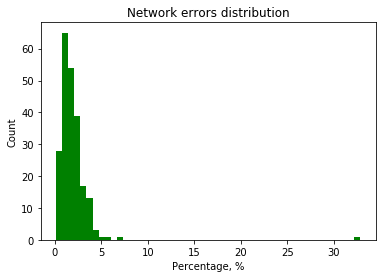

In [35]:
err = [d[1] for d in errors]

n, bins, patches = plt.hist(err, 50, facecolor='green')

plt.xlabel('Percentage, %')
plt.ylabel('Count')
plt.title('Network errors distribution')

### Покажем результаты

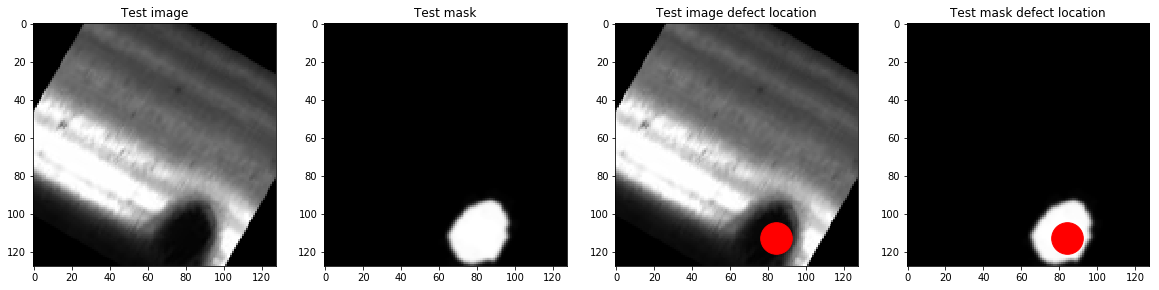

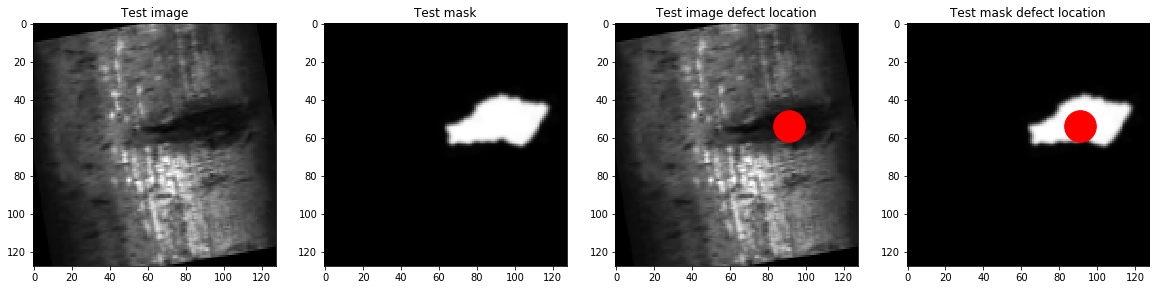

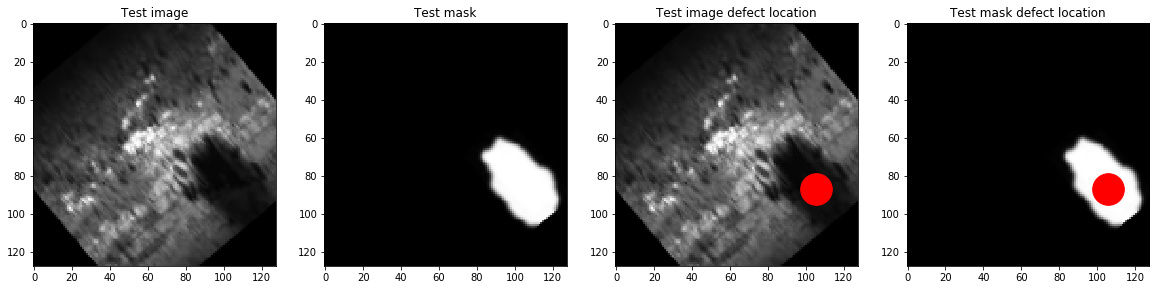

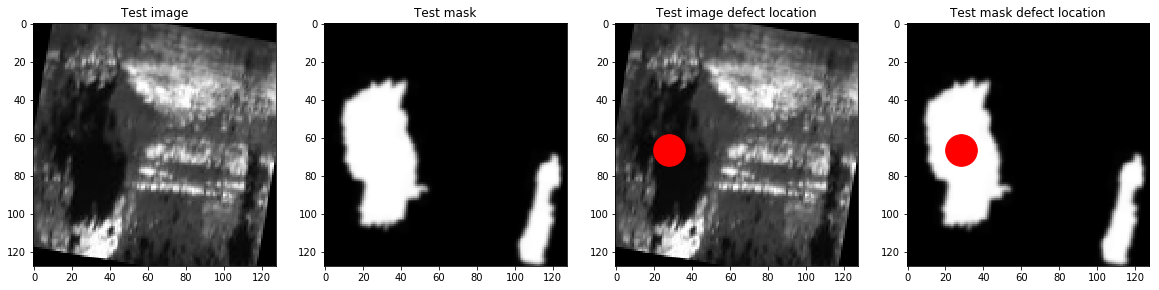

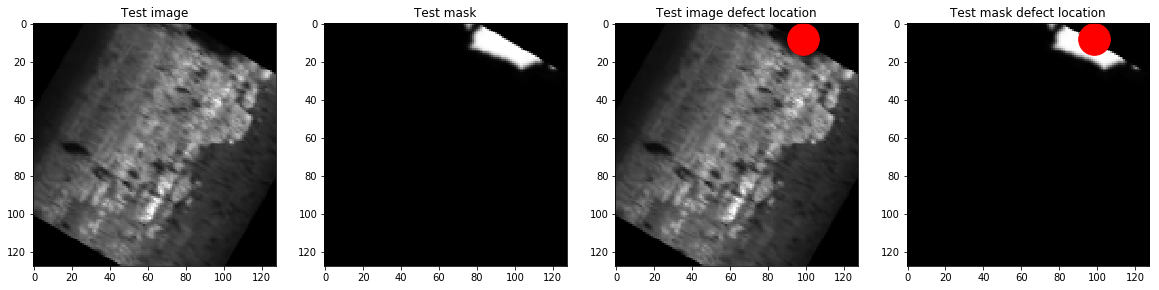

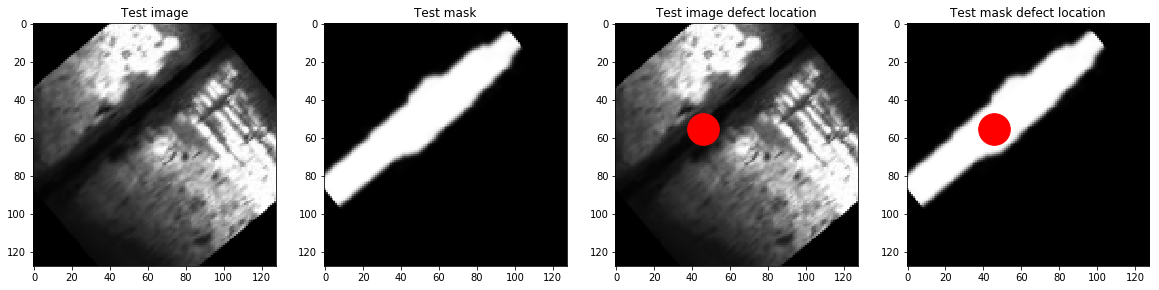

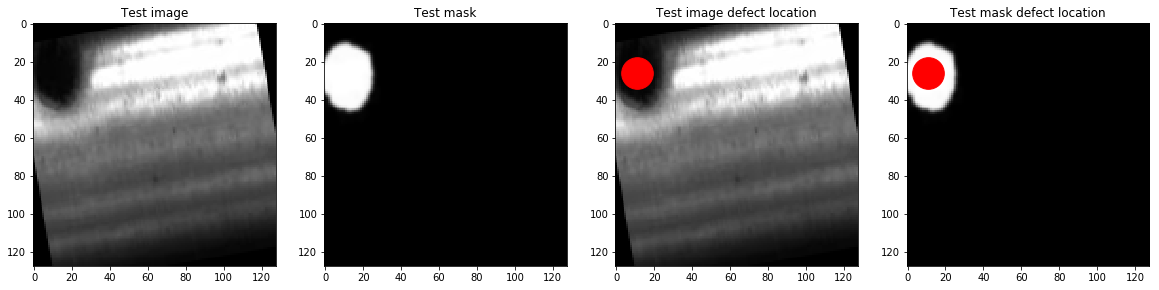

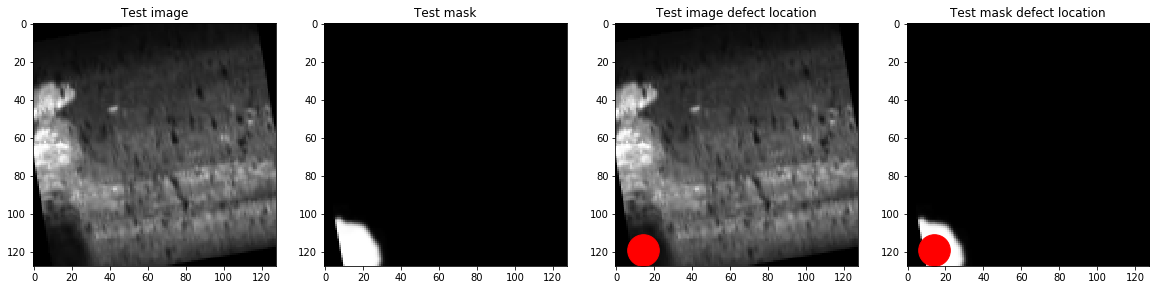

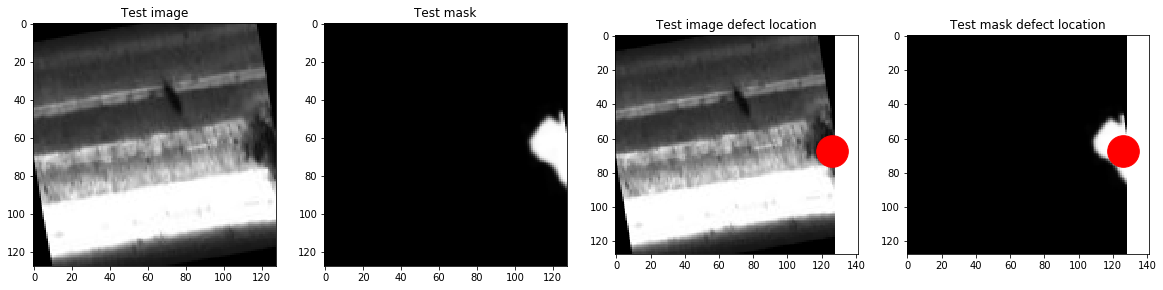

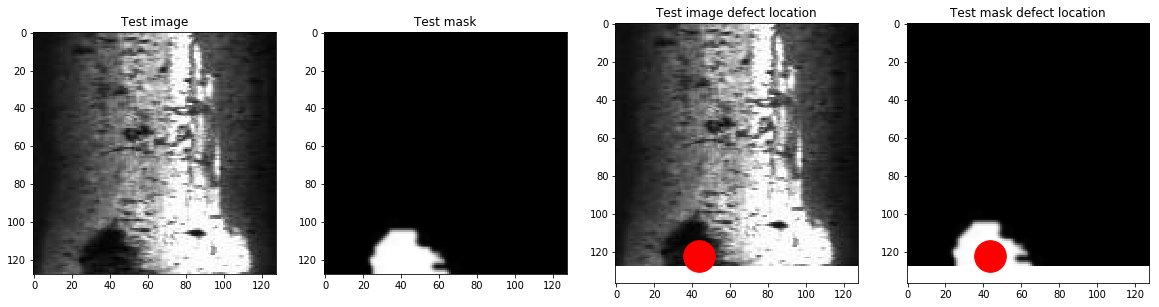

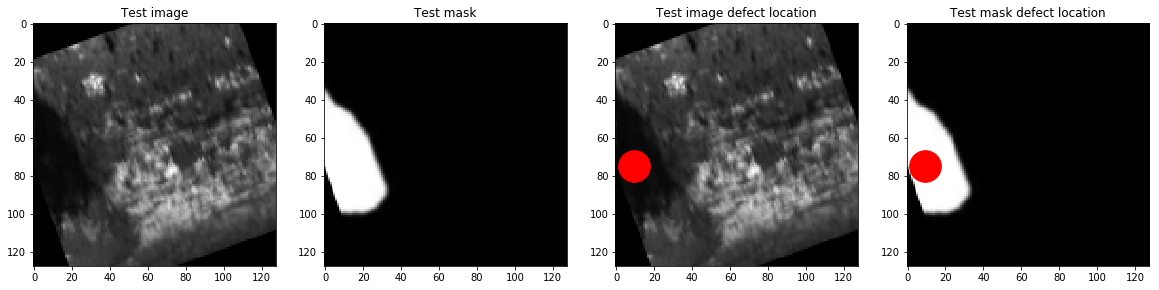

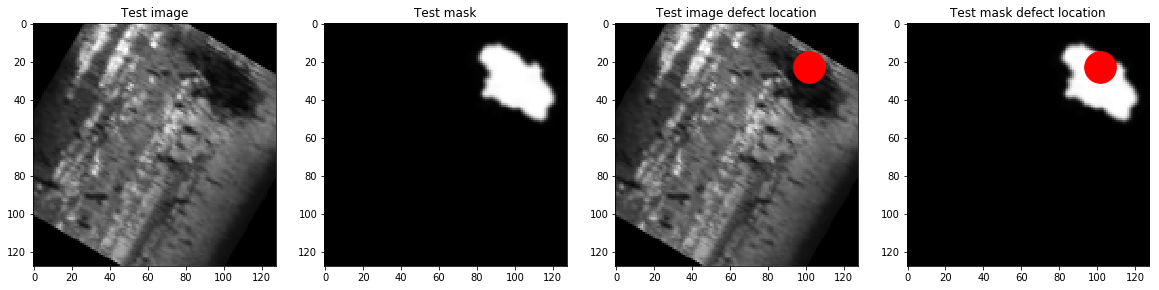

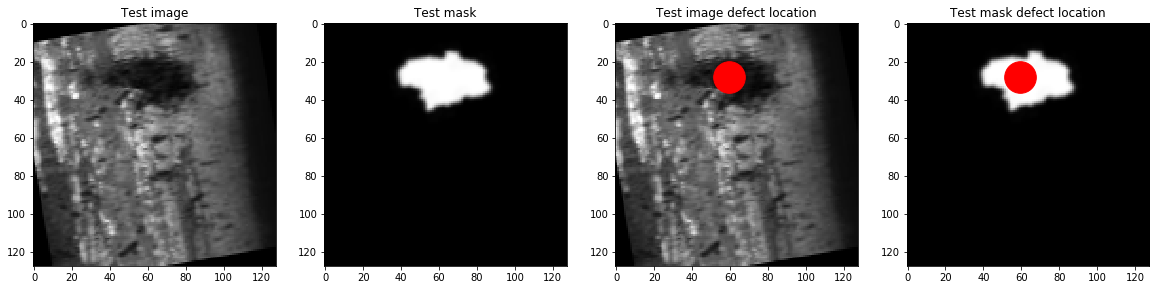

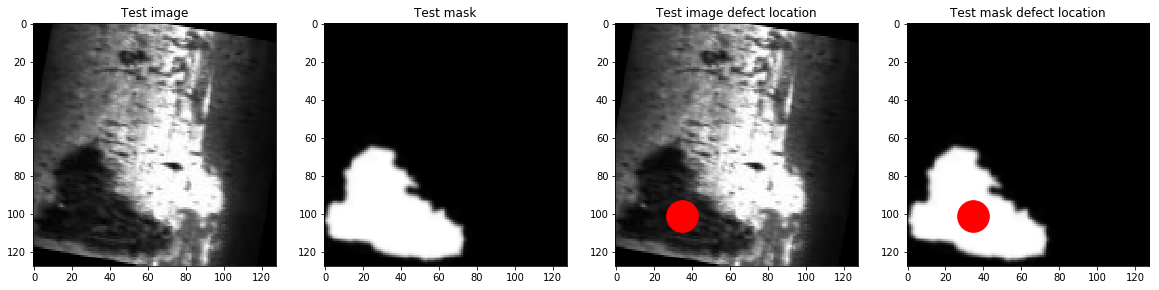

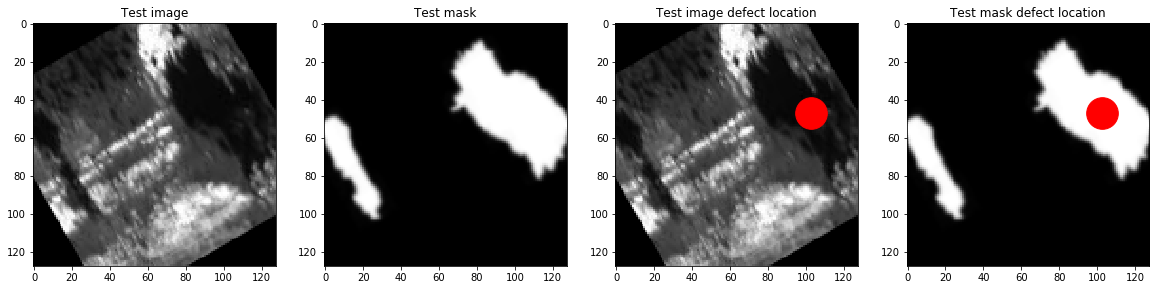

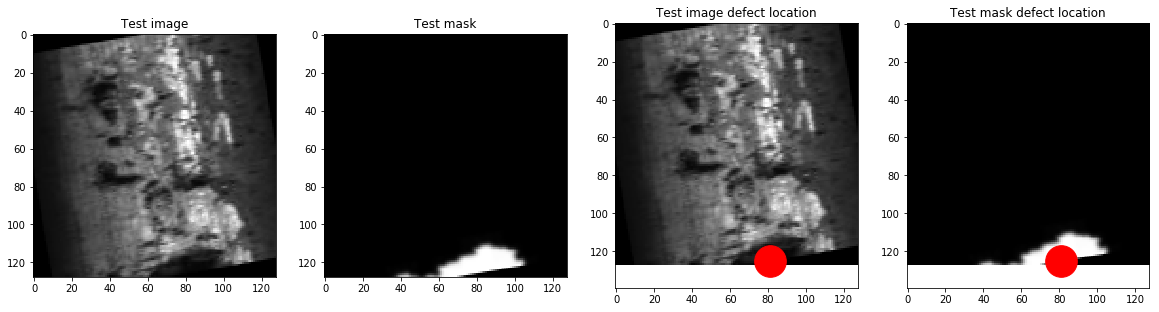

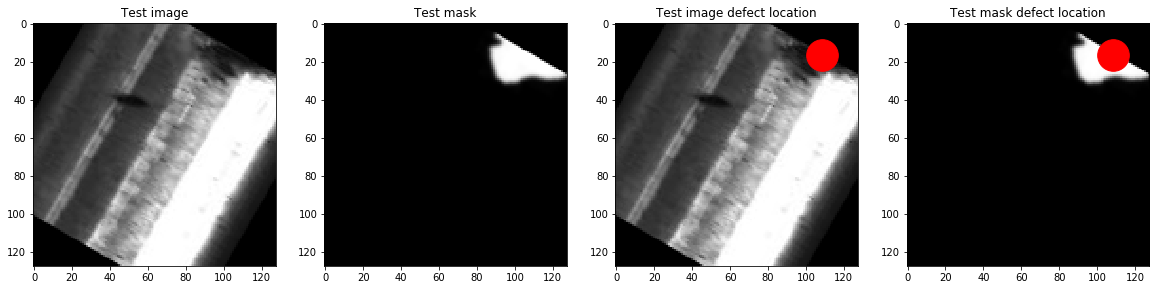

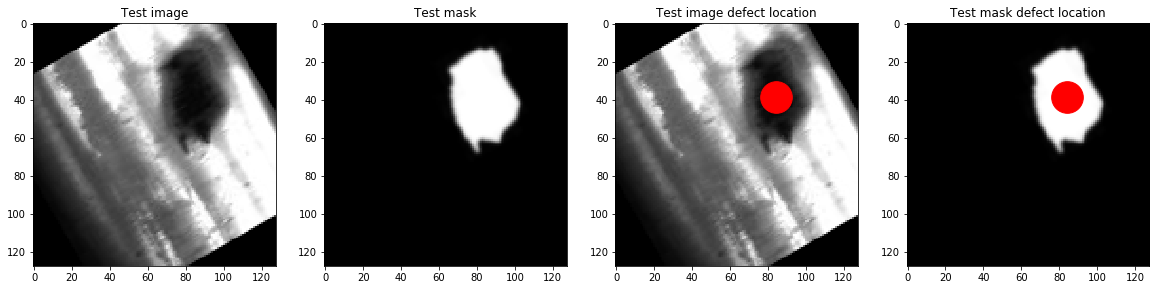

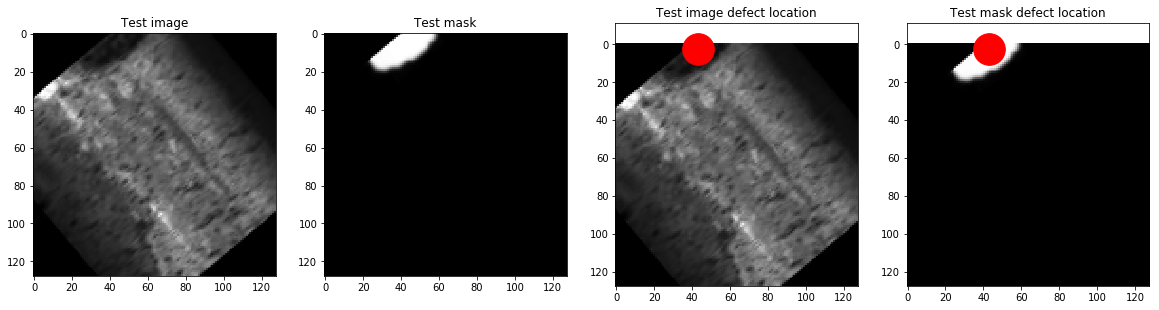

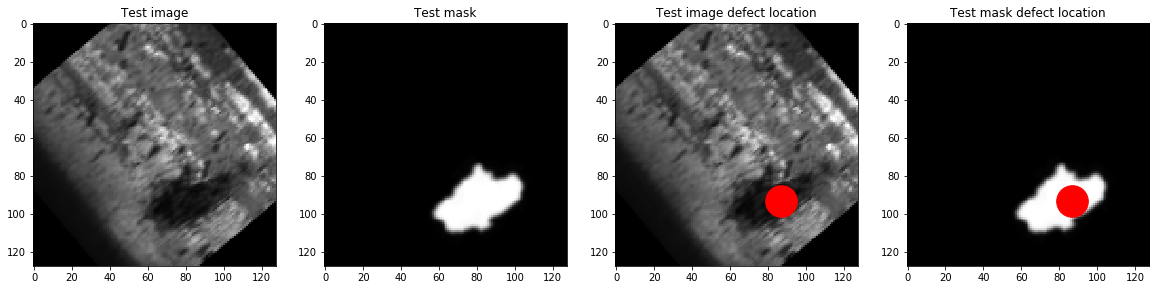

In [24]:
for i in range(20):
    test_image = augmented_dataset[i][0]
    mask_image = augmented_dataset[i][1]
    x, y = model.predict(np.array([test_image.reshape((sample_size, sample_size, 1))]))[0]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))   
    ax[0].set_title('Test image')
    ax[0].imshow(test_image.reshape(sample_size, sample_size), cmap='gray')
    ax[1].set_title('Test mask')
    ax[1].imshow(mask_image.reshape(sample_size, sample_size), cmap='gray')  
    ax[2].set_title('Test image defect location')
    ax[2].imshow(test_image.reshape(sample_size, sample_size), cmap='gray')
    ax[2].scatter(y * sample_size, x * sample_size, s=1000, c='red')
    ax[3].set_title('Test mask defect location')
    ax[3].imshow(mask_image.reshape(sample_size, sample_size), cmap='gray')
    ax[3].scatter(y * sample_size, x * sample_size, s=1000, c='red')

### Загрузим другой датасет и проведем валидацию на нем

In [62]:
images = imread_collection('dataset\Type-II RSDDs dataset\Rail surface images\*.jpg', True)
masks = imread_collection('dataset\Type-II RSDDs dataset\GroundTruth\*.jpg', True)

print('Изображений в датасете: {}, {}'.format(len(images), len(masks)))

Изображений в датасете: 128, 128


### Проведем аугментацию данных (случайные number_of_subsamples фрагментов изображения)

In [63]:
sample_size = 128
number_of_subsamples = 5

augmented_dataset = []

for i, img in enumerate(images):
    gray_image = rgb2gray(img)
    gray_mask = rgb2gray(masks[i])
    
    for _ in range(number_of_subsamples):
        # Получаем случайные координаты
        sample_size = 51
        random_x = random.randint(0, gray_image.shape[1] - sample_size)
        random_y = random.randint(0, gray_image.shape[0] - sample_size)
        
        # Берем случайный квадрат изображения
        random_image_subsample = gray_image[random_y:random_y+sample_size, random_x:random_x+sample_size]
        random_mask_subsample = gray_mask[random_y:random_y+sample_size, random_x:random_x+sample_size]
        
        # Убираем шумы
        random_mask_subsample = gaussian(random_mask_subsample)
        
        # Если в регион попал дефект
        if np.count_nonzero(random_mask_subsample) / (sample_size * sample_size) >= 0:        
            # Вращаем образцы
            for angle in range(0, 360, 10):
                rotated_random_image_subsample = rotate(random_image_subsample, angle)
                rotated_random_mask_subsample = rotate(random_mask_subsample, angle)
                    
                # Находим регион дефекта
                labels = label(rotated_random_mask_subsample)
                regions = regionprops(labels)
                    
                if len(regions) == 1:
                    rotated_random_mask_region_center = np.array((regions[0].centroid[0], regions[0].centroid[1])) * (128/51)
                    
                    # Увеличиваем размер изображения до 128*128
                    sample_size = 128
                    rotated_random_image_subsample = resize(rotated_random_image_subsample,
                                                            (sample_size, sample_size),
                                                            mode='reflect')
                    
                    rotated_random_mask_subsample = resize(rotated_random_mask_subsample,
                                                           (sample_size, sample_size),
                                                           mode='reflect')
                    
                    augmented_dataset.append((rotated_random_image_subsample,
                                              rotated_random_mask_subsample,
                                              rotated_random_mask_region_center))
        
np.random.shuffle(augmented_dataset)

np.save('dataset.npy', augmented_dataset)
        
print('Размер набора данных: {}'.format(len(augmented_dataset)))

Размер набора данных: 151


### Посмотрим на результат аугментации

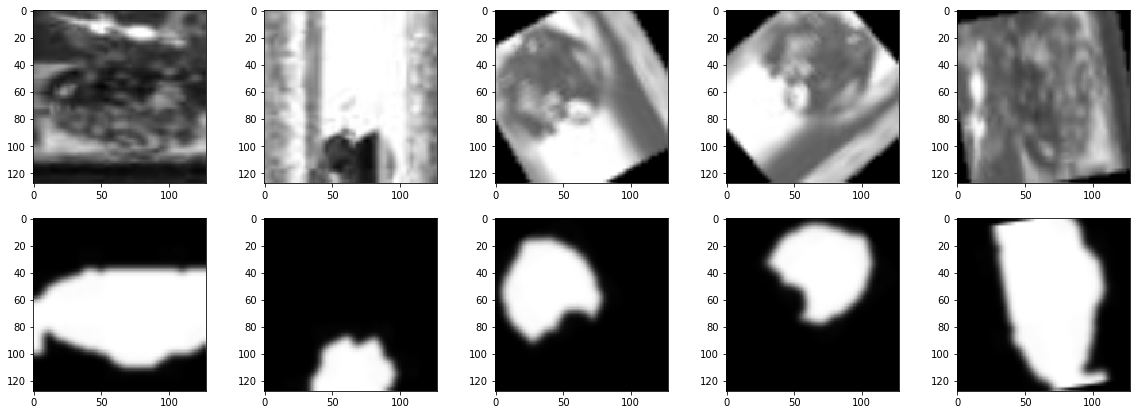

In [64]:
augmented_dataset = np.load('dataset.npy')

fig, ax = plt.subplots(2, 5, figsize=(20, 7))
for i in range(5):
    rnd = np.random.randint(0, len(augmented_dataset))
    ax[0, i].imshow(augmented_dataset[rnd][0], cmap='gray')
    ax[1, i].imshow(augmented_dataset[rnd][1], cmap='gray')

### Подготовим данные для обучения

In [65]:
dataset = np.load('dataset.npy')

train_ratio = 0.001
train, test = dataset[:int(len(dataset) * train_ratio)], dataset[int(len(dataset) * train_ratio):]

train_x, train_y, test_x, test_y = train[:, 0], train[:, 2], test[:, 0], test[:, 2]

print('В обучающем наборе элементов: {}, в тестовом {}'.format(len(train_x), len(test_x)))

В обучающем наборе элементов: 0, в тестовом 151


### Преобразуем данные к 4D формату

In [66]:
sample_size = 128
train_x_norm = np.array([d.reshape((sample_size, sample_size, 1)) for d in train_x]).astype(np.float32)
train_y_norm = np.array([d for d in train_y]).astype(np.float32) / (sample_size)
test_x_norm = np.array([d.reshape((sample_size, sample_size, 1)) for d in test_x]).astype(np.float32)
test_y_norm = np.array([d for d in test_y]).astype(np.float32) / (sample_size)

### Проводим валидацию на тестовой выборке

In [67]:
model = models.load_model('network')
results = model.predict(test_x_norm)

### Расчитываем ошибку и показываем результаты работы (по возрастанию ошибки)

In [68]:
errors = []

for i in range(len(test_y_norm)):
    err = np.abs(test_y_norm[i] - results[i]) / 1 * 100    
    errors.append((i, np.round((err[0] + err[1]) / 2, 2), results[i] * sample_size, test_y_norm[i] * sample_size))

for d in sorted(errors, key=lambda x: x[1]):
    print('#{}\tError:{}\tPredict: {}\tActual: {}'.format(d[0], d[1], d[2], d[3]))
    
print('\nAverage error: {}'.format(np.average([d[1] for d in errors])))

#42	Error:1.7	Predict: [ 89.53866577  64.29605865]	Actual: [ 89.09803772  60.38588333]
#71	Error:2.54	Predict: [ 93.65371704  63.31639862]	Actual: [ 89.09803772  65.2549057 ]
#120	Error:3.18	Predict: [ 72.01772308  84.38370514]	Actual: [ 79.23929596  83.45307922]
#53	Error:3.32	Predict: [ 73.12807465  62.12805176]	Actual: [ 70.27451324  67.76470947]
#12	Error:4.64	Predict: [ 87.23800659  62.80194473]	Actual: [ 86.58823395  74.03921509]
#69	Error:4.65	Predict: [ 67.08939362  66.43431854]	Actual: [ 67.76470947  55.2156868 ]
#19	Error:5.23	Predict: [ 66.9786377   78.91414642]	Actual: [ 71.21672821  88.05992889]
#26	Error:5.33	Predict: [ 65.03291321  82.93106079]	Actual: [ 75.41960907  86.17829895]
#52	Error:5.38	Predict: [ 97.52430725  65.13314819]	Actual: [ 88.29489899  69.67215729]
#37	Error:5.41	Predict: [ 74.40625763  74.89742279]	Actual: [ 82.74823761  80.41411591]
#81	Error:5.74	Predict: [ 70.54179382  68.39130402]	Actual: [ 57.72549057  70.27451324]
#16	Error:5.93	Predict: [ 84.330

### Покажем распределение ошибок на тестовом датасете

Text(0.5,1,'Network errors distribution')

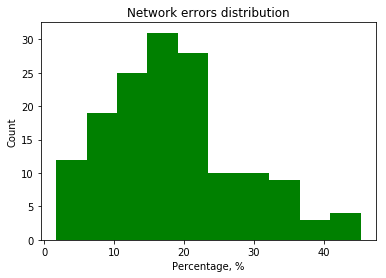

In [75]:
err = [d[1] for d in errors]

n, bins, patches = plt.hist(err, 10, facecolor='green')

plt.xlabel('Percentage, %')
plt.ylabel('Count')
plt.title('Network errors distribution')

### Покажем результаты

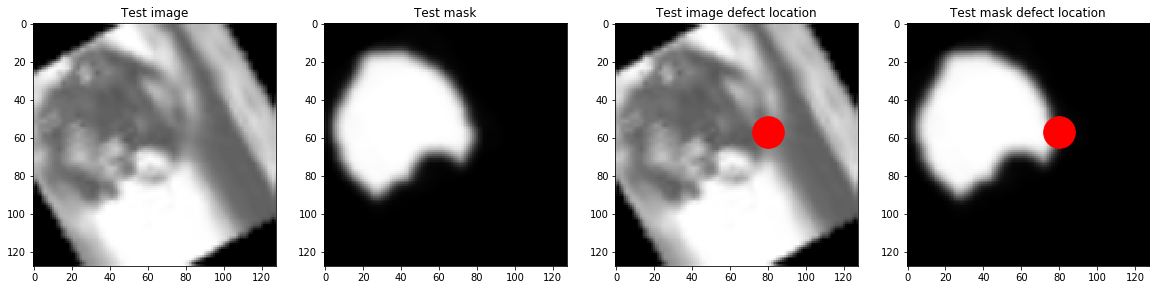

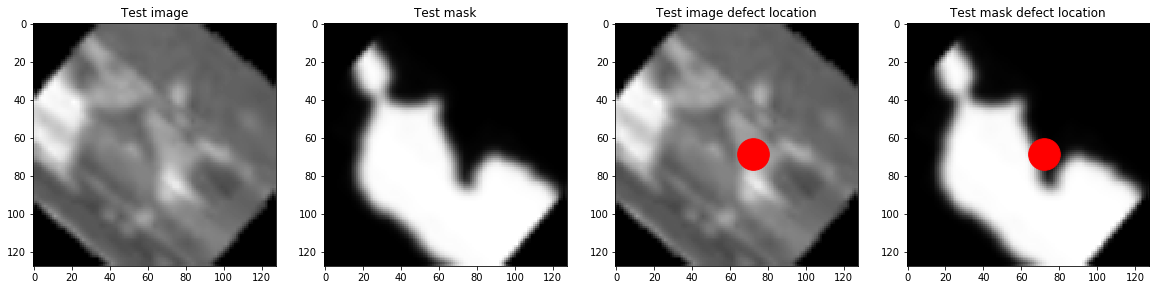

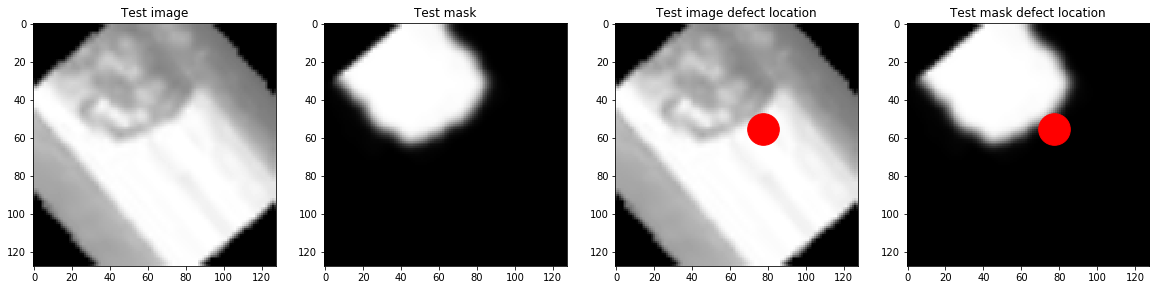

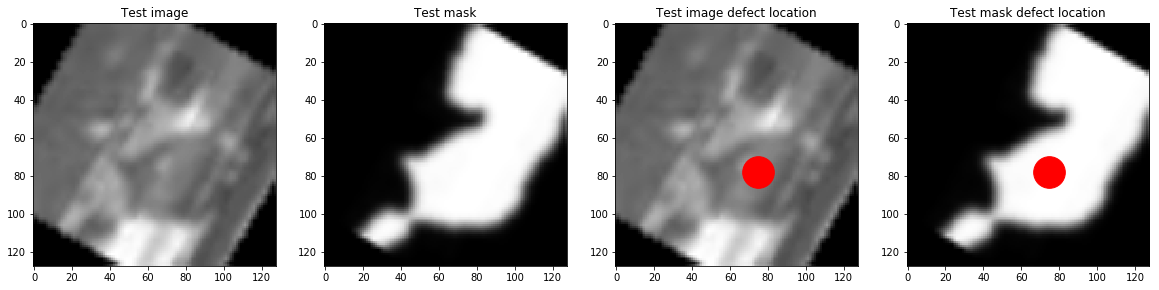

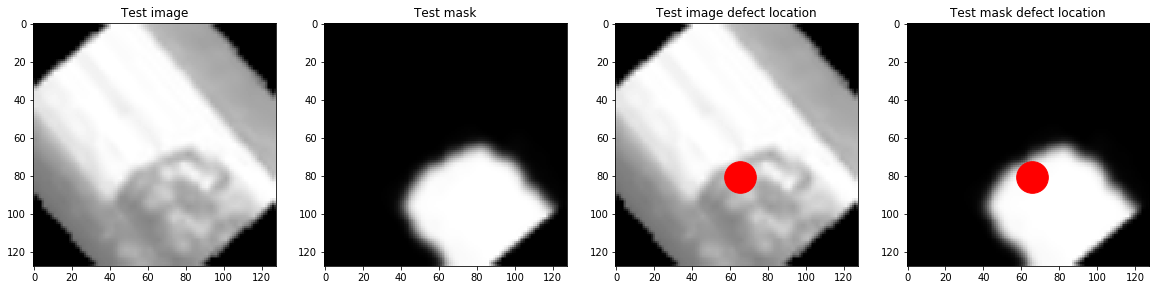

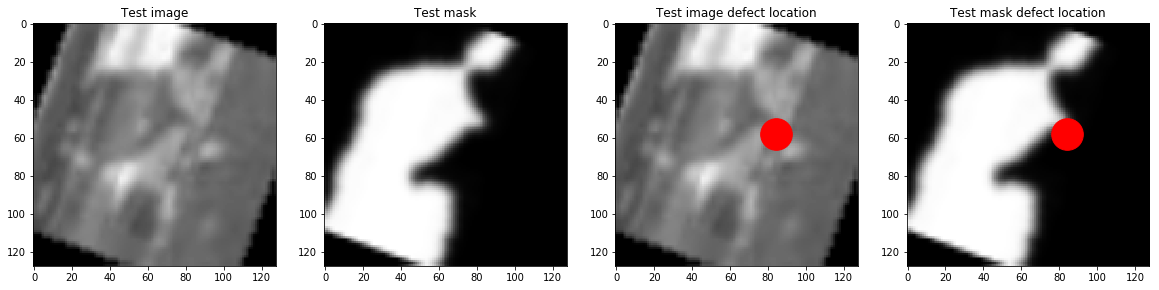

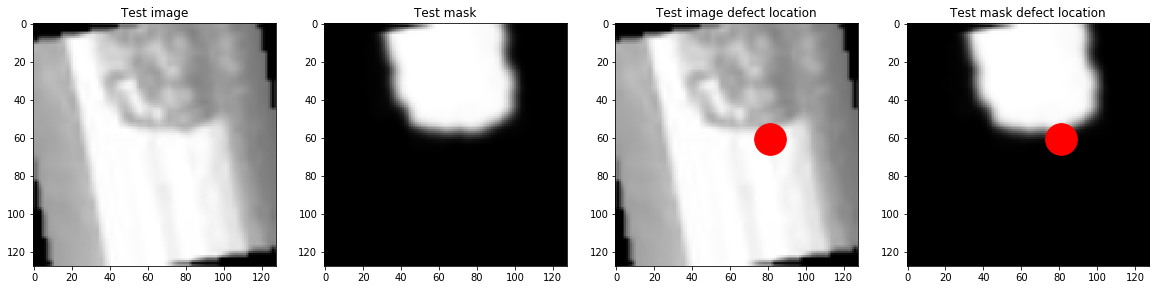

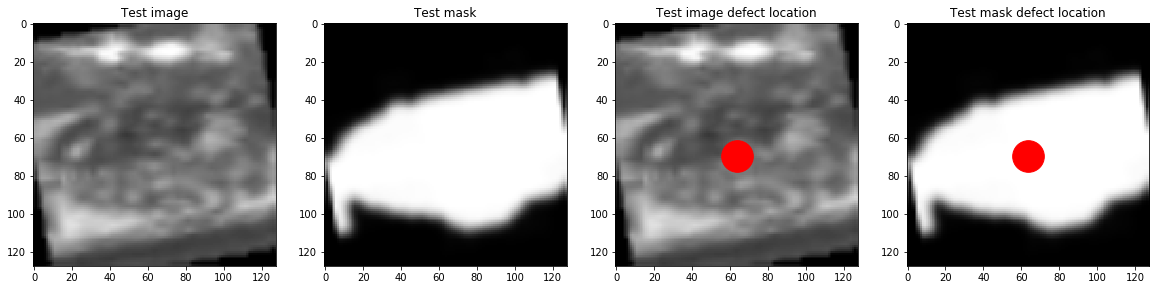

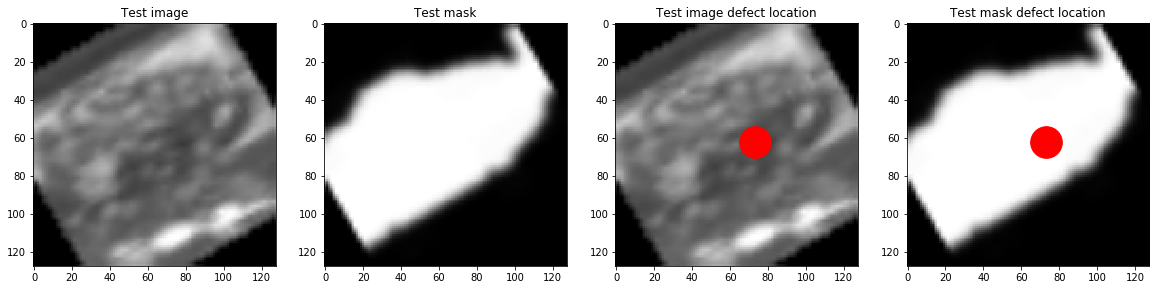

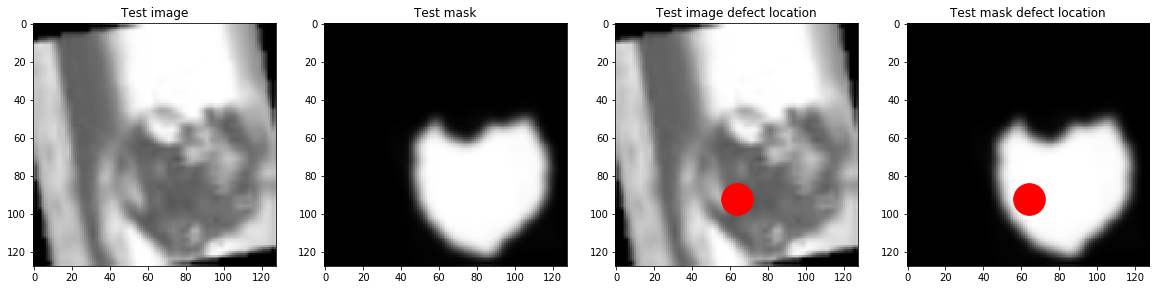

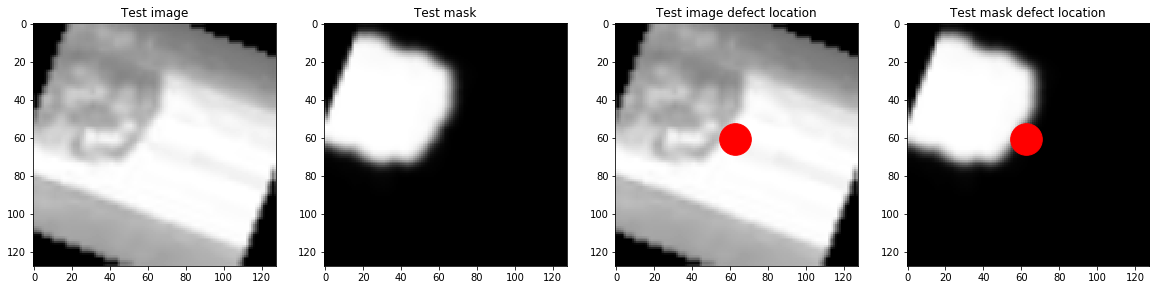

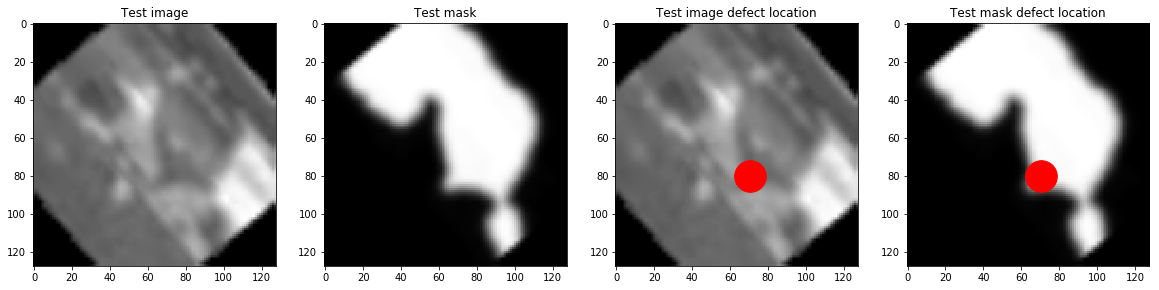

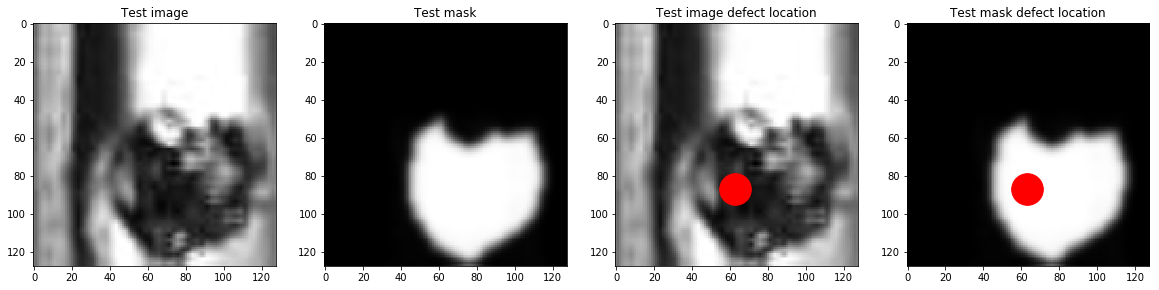

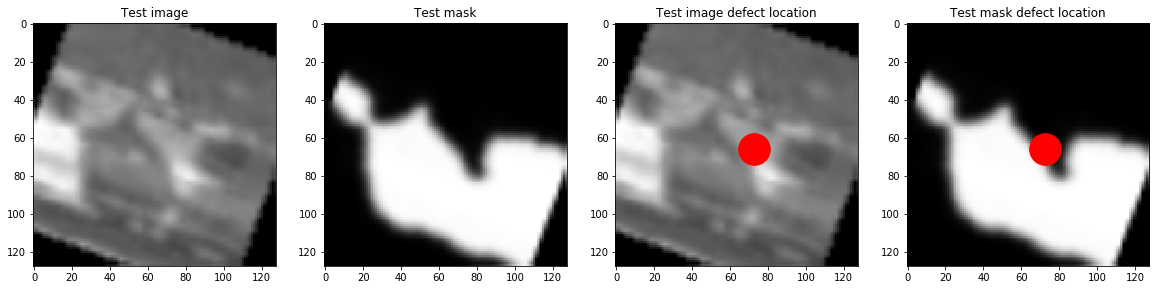

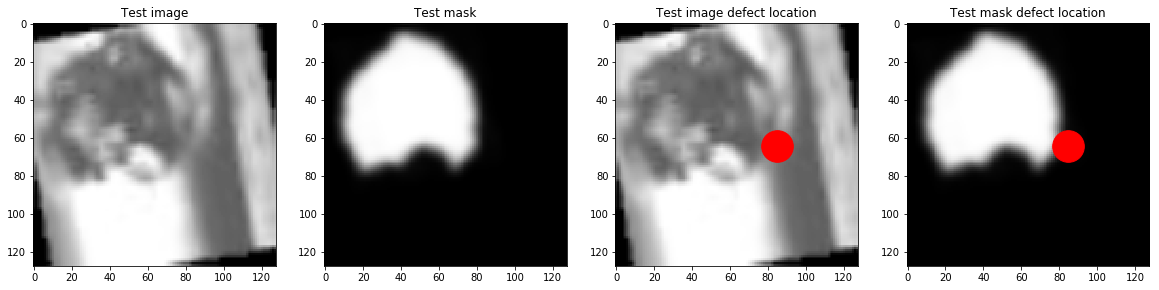

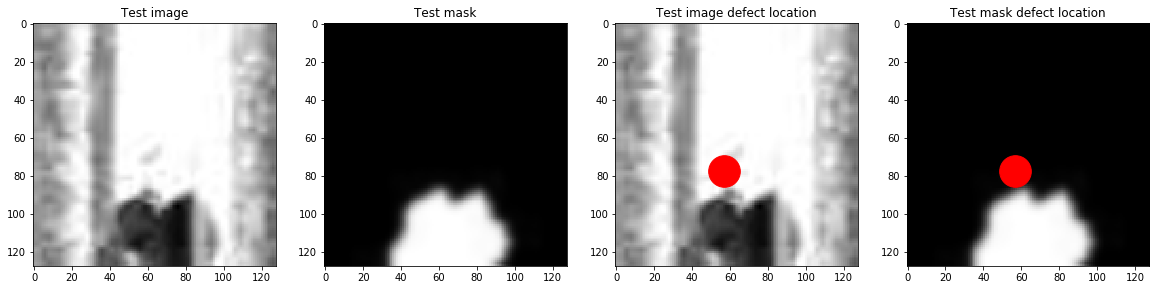

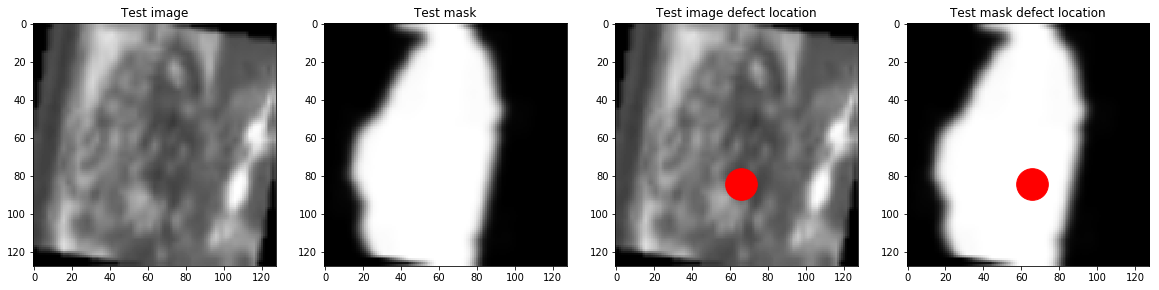

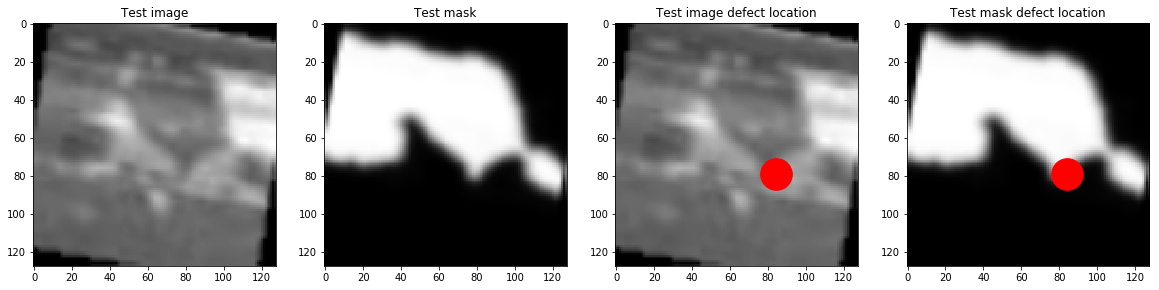

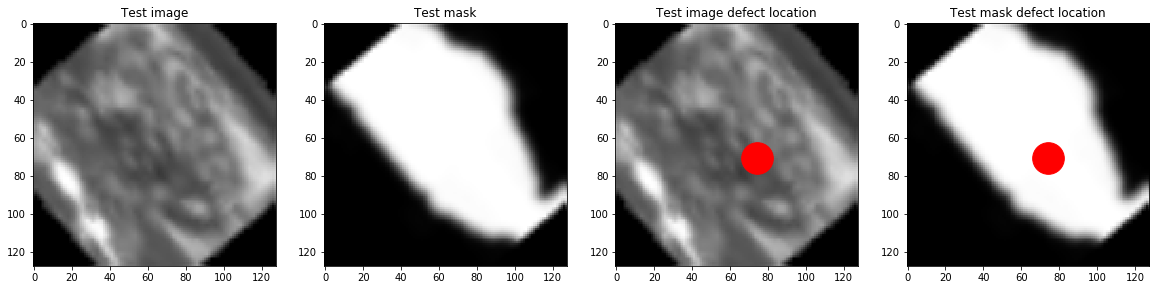

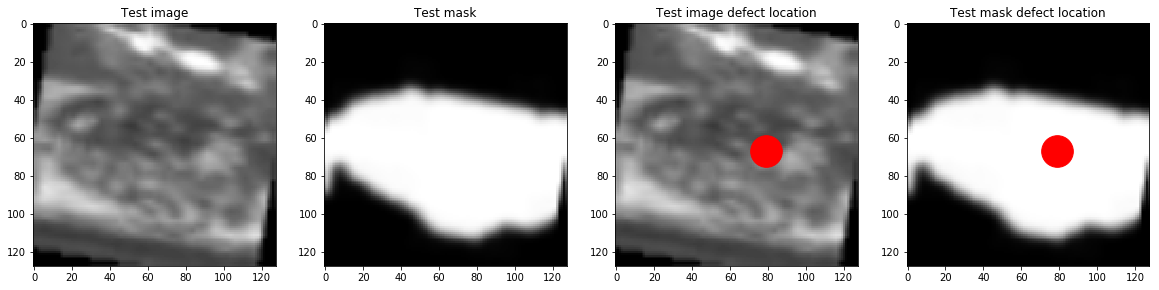

In [70]:
for i in range(20):
    test_image = augmented_dataset[i][0]
    mask_image = augmented_dataset[i][1]
    x, y = model.predict(np.array([test_image.reshape((sample_size, sample_size, 1))]))[0]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))   
    ax[0].set_title('Test image')
    ax[0].imshow(test_image.reshape(sample_size, sample_size), cmap='gray')
    ax[1].set_title('Test mask')
    ax[1].imshow(mask_image.reshape(sample_size, sample_size), cmap='gray')  
    ax[2].set_title('Test image defect location')
    ax[2].imshow(test_image.reshape(sample_size, sample_size), cmap='gray')
    ax[2].scatter(y * sample_size, x * sample_size, s=1000, c='red')
    ax[3].set_title('Test mask defect location')
    ax[3].imshow(mask_image.reshape(sample_size, sample_size), cmap='gray')
    ax[3].scatter(y * sample_size, x * sample_size, s=1000, c='red')